In [1]:
# Imports
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  
from sklearn.preprocessing import StandardScaler

# Project Overview

- Build a Machine Learning Model to predict 2024 NFL player fantasy points 
- Make an application to output the best players to use on draft day
- A fantasy team consists of 1 qb, 2 RB, 2 WR, 1 TE, 2 flex which means 2 of any RB,WR,TE and 1 team defense, 6 bench. So I will need roughly the top 20 QB and 50 of each attacking position. 
- Each position values different performance indicators so we need 4 different models
- Goal is to use Age, Expierence and Historical trends to predict a players next season performance levels and therefore total fantasy points to allow me to win my neighborhood fantasy league

In [2]:
# Read in Player Data for NFL football years 2013-2023
NFL_Player_Data = pd.read_csv(r"D:\NFL_Player_Data.csv")

In [3]:
NFL_Player_Data.head()

,id,name,height_ft,height_cm,position,team,season,season_type,completions,attempts,...,pr,rookie_season,round,overall,forty,bench,vertical,years_played,fp_ps,ppr_fp_ps
0,1,A.J. Brown,"6'1""",73.0,WR,TEN,2019,REG,0,0,...,33.87,2019,2.0,51.0,4.49,19.0,36.5,1,0.24,0.32
1,1,A.J. Brown,"6'0""",72.0,WR,TEN,2020,REG,0,0,...,33.87,2019,2.0,51.0,4.49,19.0,36.5,2,0.23,0.33
2,1,A.J. Brown,"6'1""",73.0,WR,TEN,2021,REG,0,2,...,33.87,2019,2.0,51.0,4.49,19.0,36.5,3,0.20,0.30
3,1,A.J. Brown,"6'1""",73.0,WR,PHI,2022,REG,0,0,...,33.87,2019,2.0,51.0,4.49,19.0,36.5,4,0.21,0.30
4,1,A.J. Brown,"6'1""",73.0,WR,PHI,2023,REG,0,0,...,33.87,2019,2.0,51.0,4.49,19.0,36.5,5,0.18,0.28


In [4]:
# look at col headers to determine features for model
# We need to determine the important stats for each position
print(NFL_Player_Data.columns)

Index(['id', 'name', 'height_ft', 'height_cm', 'position', 'team', 'season',
       'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_2pt_conversions', 'carries',
       'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_2pt_conversions', 'target_share',
       'air_yards_share', 'fantasy_points', 'fantasy_points_ppr',
       'total_yards', 'games', 'offense_snaps', 'teams_offense_snaps', 'ypa',
       'ypc', 'ypr', 'touches', 'count', 'comp_percentage',
       'pass_td_percentage', '

# Dataset Cleaning and Prep

In [5]:
# Dataset Cleaning and Adding Columns for 2024 Prediction

# Create experience column utilizing the rookie_season existing column 
NFL_Player_Data['experience'] = NFL_Player_Data['season'] - NFL_Player_Data['rookie_season']

# Sort data by player and season 
NFL_Player_Data = NFL_Player_Data.sort_values(by=['id', 'season'])

# Remove retired players from 2024 predictions. (assumption not appearing in dataset for two seasons in a row)
NFL_Player_Data['retired'] = NFL_Player_Data.groupby('id')['season'].diff().fillna(1) > 2
NFL_Player_Data['retired'] = NFL_Player_Data.groupby('id')['retired'].cumsum() > 0

# Create historical performance trend predictor variable 
NFL_Player_Data['fp_trend'] = NFL_Player_Data.groupby('id')['fantasy_points'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)

# Create performance change from previous season predictor variable
NFL_Player_Data['fp_change'] = NFL_Player_Data.groupby('id')['fantasy_points'].diff()
NFL_Player_Data['fp_change'].fillna(0, inplace=True)

# Handle missing values 
NFL_Player_Data.drop(columns=['offense_pct'], inplace=True) # Drop the 'offense_pct' column (165/182 missing values in the dataset)
NFL_Player_Data.drop(columns=['yps'], inplace=True) # Drop this as well. 7/182 missing values and we also dont need it 

# There are 10 more values missing and we will use the players average across all their seasons. 

C:\Users\blake\AppData\Local\Temp\ipykernel_23540\659952186.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  NFL_Player_Data['fp_change'].fillna(0, inplace=True)


In [6]:
# Prep Position Datasets by filtering out all positions besides the model topic

# Quarterback (QB)
data_qb = NFL_Player_Data[NFL_Player_Data['position'] == 'QB']

# Running Back (RB)
data_rb = NFL_Player_Data[NFL_Player_Data['position'] == 'RB']

# Wide Receiver (WR)
data_wr = NFL_Player_Data[NFL_Player_Data['position'] == 'WR']

# Tight End (TE)
data_te = NFL_Player_Data[NFL_Player_Data['position'] == 'TE']

# Modeling 

In [7]:
# Create features for each position with positional stats that relate to fantasy points and 2024 prediction variables. Match column headers with scoring metrics of fantasy football 

qb_features = [
    'passing_yards',           # Passing Yards
    'passing_tds',             # Passing Touchdowns
    'interceptions',           # Interceptions
    'passing_2pt_conversions', # 2pt Passing Conversions
    'rushing_yards',           # Rushing Yards
    'rushing_tds',             # Rushing Touchdowns
    'rushing_2pt_conversions', # 2pt Rushing Conversions
    'experience',              # Years in NFL
    'fp_trend',                # Rolling average of fantasy points
    'fp_change'                # Change in fantasy points from previous season
]

rb_features = [
    'rushing_yards',           # Rushing Yards
    'rushing_tds',             # Rushing Touchdowns
    'receptions',              # Receptions
    'receiving_yards',         # Receiving Yards
    'receiving_tds',           # Receiving Touchdowns
    'rushing_2pt_conversions', # 2pt Rushing Conversions
    'receiving_2pt_conversions', # 2pt Receiving Conversions
    'experience',              # Years in NFL
    'fp_trend',                # Rolling average of fantasy points
    'fp_change'                # Change in fantasy points from previous season
]

wr_features = [
    'receptions',              # Receptions
    'receiving_yards',         # Receiving Yards
    'receiving_tds',           # Receiving Touchdowns
    'rushing_yards',           # Rushing Yards 
    'rushing_tds',             # Rushing Touchdowns 
    'rushing_2pt_conversions', # 2pt Rushing Conversions 
    'receiving_2pt_conversions', # 2pt Receiving Conversions
    'experience',              # Years in NFL
    'fp_trend',                # Rolling average of fantasy points
    'fp_change'                # Change in fantasy points from previous season
]

te_features = [
    'receptions',              # Receptions (0.5 points per reception in 1/2 PPR)
    'receiving_yards',         # Receiving Yards
    'receiving_tds',           # Receiving Touchdowns
    'rushing_yards',           # Rushing Yards 
    'rushing_tds',             # Rushing Touchdowns 
    'rushing_2pt_conversions', # 2pt Rushing Conversions 
    'receiving_2pt_conversions', # 2pt Receiving Conversions
    'experience',              # Years in NFL
    'fp_trend',                # Rolling average of fantasy points
    'fp_change'                # Change in fantasy points from previous season
]


Linear Regression vs Random Forest vs Neural Networks to model future 2024 performance 

- Linear Regression should be strong due to the somewhat formulaic nature of this project. 
It assumes a linear relationship between the predictor variables and the dependent variable which there should be in this instance. 

- Random Forest doesn’t assume linearity and is less sensitive to outliers, which is very helpful in this instance if a player has one incredible season and falls back to more expected performance levels. Random forest is much better at modeling complex relationships and adding experience and momentum trends might be a complex nature instead of linear. 

- Neural Network are very flexible and powerful although very computationally intensive. Neural networks are best at learning feature interactions so they might be able to capture deeper relationships within the data. They are a good midpoint in complexity between regression and random forest. 

In [8]:
# Define models for QB
models_qb = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Prepare data for QB
X_qb = data_qb[qb_features]
y_qb = data_qb['fantasy_points']

# Handle missing values using the player's average
imputer_qb = SimpleImputer(strategy='mean')
X_qb = pd.DataFrame(imputer_qb.fit_transform(X_qb), columns=X_qb.columns)

# Split the data into training and testing sets
X_train_qb, X_test_qb, y_train_qb, y_test_qb = train_test_split(X_qb, y_qb, test_size=0.2, random_state=42)

# Reset indices due to alignment issues
X_train_qb.reset_index(drop=True, inplace=True)
y_train_qb.reset_index(drop=True, inplace=True)

# Initialize the models for QB
model_dict_qb = {}

for model_name_qb, model_qb in models_qb.items():
    # Train the model
    model_qb.fit(X_train_qb, y_train_qb)
    
    # Store the trained model
    model_dict_qb[f'qb_{model_name_qb}'] = model_qb
    
    # Make predictions on the test set
    y_pred_qb = model_qb.predict(X_test_qb)
    
    # Calculate R-squared
    r2_qb = r2_score(y_test_qb, y_pred_qb)
    print(f"QB {model_name_qb} R-squared: {r2_qb:.4f}")
    
    # Print summary for the Linear Regression model
    if model_name_qb == 'Linear Regression':
        X_train_qb_const = sm.add_constant(X_train_qb)  # Adding a constant term for the intercept
        model_sm_qb = sm.OLS(y_train_qb, X_train_qb_const).fit()
        print(model_sm_qb.summary())


QB Linear Regression R-squared: 0.9994
                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.423e+04
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:58:03   Log-Likelihood:                -1677.0
No. Observations:                 601   AIC:                             3376.
Df Residuals:                     590   BIC:                             3424.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [9]:
# Define models for RB
models_rb = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Prepare data for RB
X_rb = data_rb[rb_features]
y_rb = data_rb['fantasy_points']

# Handle missing values using the player's average
imputer_rb = SimpleImputer(strategy='mean')
X_rb = pd.DataFrame(imputer_rb.fit_transform(X_rb), columns=X_rb.columns)

# Split the data into training and testing sets
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(X_rb, y_rb, test_size=0.2, random_state=42)

# Reset indices due to alignment issues
X_train_rb.reset_index(drop=True, inplace=True)
y_train_rb.reset_index(drop=True, inplace=True)

# Initialize the models for RB
model_dict_rb = {}

for model_name_rb, model_rb in models_rb.items():
    # Train the model
    model_rb.fit(X_train_rb, y_train_rb)
    
    # Store the trained model
    model_dict_rb[f'rb_{model_name_rb}'] = model_rb
    
    # Make predictions on the test set
    y_pred_rb = model_rb.predict(X_test_rb)
    
    # Calculate R-squared
    r2_rb = r2_score(y_test_rb, y_pred_rb)
    print(f"RB {model_name_rb} R-squared: {r2_rb:.4f}")
    
    # Print summary for the Linear Regression model
    if model_name_rb == 'Linear Regression':
        X_train_rb_const = sm.add_constant(X_train_rb)  # Adding a constant term for the intercept
        model_sm_rb = sm.OLS(y_train_rb, X_train_rb_const).fit()
        print(model_sm_rb.summary())


RB Linear Regression R-squared: 0.9992
                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.790e+05
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:58:03   Log-Likelihood:                -2240.4
No. Observations:                1133   AIC:                             4503.
Df Residuals:                    1122   BIC:                             4558.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [10]:
# Define models for WR
models_wr = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Prepare data for WR
X_wr = data_wr[wr_features]
y_wr = data_wr['fantasy_points']

# Handle missing values using the player's average
imputer_wr = SimpleImputer(strategy='mean')
X_wr = pd.DataFrame(imputer_wr.fit_transform(X_wr), columns=X_wr.columns)

# Split the data into training and testing sets
X_train_wr, X_test_wr, y_train_wr, y_test_wr = train_test_split(X_wr, y_wr, test_size=0.2, random_state=42)

# Reset indices due to alignment issues
X_train_wr.reset_index(drop=True, inplace=True)
y_train_wr.reset_index(drop=True, inplace=True)

# Initialize the models for WR
model_dict_wr = {}

for model_name_wr, model_wr in models_wr.items():
    # Train the model
    model_wr.fit(X_train_wr, y_train_wr)
    
    # Store the trained model
    model_dict_wr[f'wr_{model_name_wr}'] = model_wr
    
    # Make predictions on the test set
    y_pred_wr = model_wr.predict(X_test_wr)
    
    # Calculate R-squared
    r2_wr = r2_score(y_test_wr, y_pred_wr)
    print(f"WR {model_name_wr} R-squared: {r2_wr:.4f}")
    
    # Print summary for the Linear Regression model
    if model_name_wr == 'Linear Regression':
        X_train_wr_const = sm.add_constant(X_train_wr)  # Adding a constant term for the intercept
        model_sm_wr = sm.OLS(y_train_wr, X_train_wr_const).fit()
        print(model_sm_wr.summary())


WR Linear Regression R-squared: 0.9988
                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.702e+05
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:58:05   Log-Likelihood:                -3354.4
No. Observations:                1680   AIC:                             6731.
Df Residuals:                    1669   BIC:                             6790.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [11]:
# Define models for TE
models_te = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Prepare data for TE
X_te = data_te[te_features]
y_te = data_te['fantasy_points']

# Handle missing values using the player's average
imputer_te = SimpleImputer(strategy='mean')
X_te = pd.DataFrame(imputer_te.fit_transform(X_te), columns=X_te.columns)

# Split the data into training and testing sets
X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(X_te, y_te, test_size=0.2, random_state=42)

# Reset indices due to alignment issues
X_train_te.reset_index(drop=True, inplace=True)
y_train_te.reset_index(drop=True, inplace=True)

# Initialize the models for TE
model_dict_te = {}

for model_name_te, model_te in models_te.items():
    # Train the model
    model_te.fit(X_train_te, y_train_te)
    
    # Store the trained model
    model_dict_te[f'te_{model_name_te}'] = model_te
    
    # Make predictions on the test set
    y_pred_te = model_te.predict(X_test_te)
    
    # Calculate R-squared
    r2_te = r2_score(y_test_te, y_pred_te)
    print(f"TE {model_name_te} R-squared: {r2_te:.4f}")
    
    # Print summary for the Linear Regression model
    if model_name_te == 'Linear Regression':
        X_train_te_const = sm.add_constant(X_train_te)  # Adding a constant term for the intercept
        model_sm_te = sm.OLS(y_train_te, X_train_te_const).fit()
        print(model_sm_te.summary())


TE Linear Regression R-squared: 0.9996
                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.853e+05
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:58:06   Log-Likelihood:                -1178.0
No. Observations:                 946   AIC:                             2378.
Df Residuals:                     935   BIC:                             2431.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Linear Regression is the best model type for each position in terms of R2. Experience time in the NFL is not an indicator of the number of fantasy points a player will score in the upcoming season which is interesting. However, it seems to be far more important in the running back position than any other position judging by its relative P-value significance. 

Overall, I have tried many different combinations of predictors and interaction terms, but these predictors produces the most interesting results. I do not want to remove more predictors because then the machine learns how to recreate 
The formula for fantasy points. You will notice that sometimes reception is not significant by P-value but what is happening is that events are very rare to occur for that position, so I chose to keep that in the model as well. 

I think it’s very interesting that fantasy point change from the season before is an indicator of performance as is a player’s trend. This implies that players don't make massive jumps in fantasy points. This somewhat makes sense because fantasy points 
are an average of all of a player’s stats. So, if they perform poorly in one area it can be counteracted by higher performances in another area. 

# Visualize the 2024 Predictions using QB 

C:\Users\blake\AppData\Local\Temp\ipykernel_23540\561485595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qb['predicted_fantasy_points_2024'] = model_dict_qb[f'qb_{model_name_qb}'].predict(X_qb)


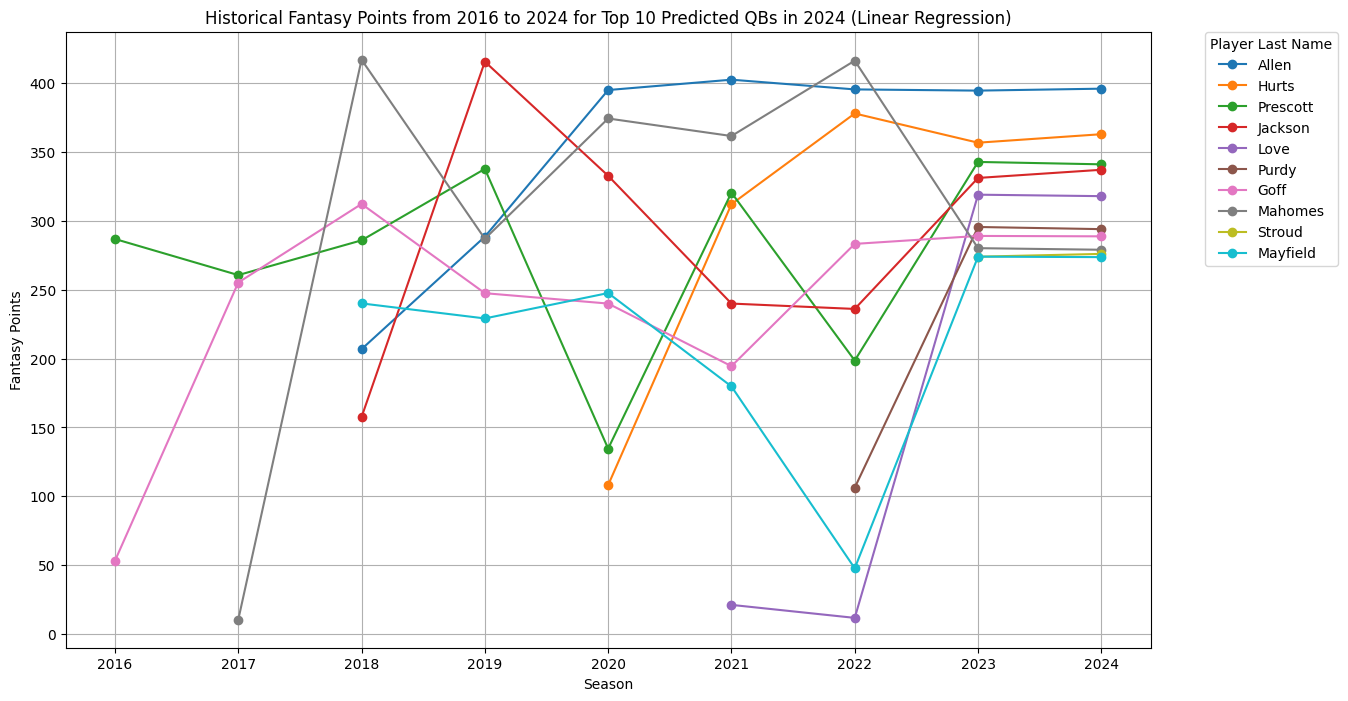

C:\Users\blake\AppData\Local\Temp\ipykernel_23540\561485595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qb['predicted_fantasy_points_2024'] = model_dict_qb[f'qb_{model_name_qb}'].predict(X_qb)


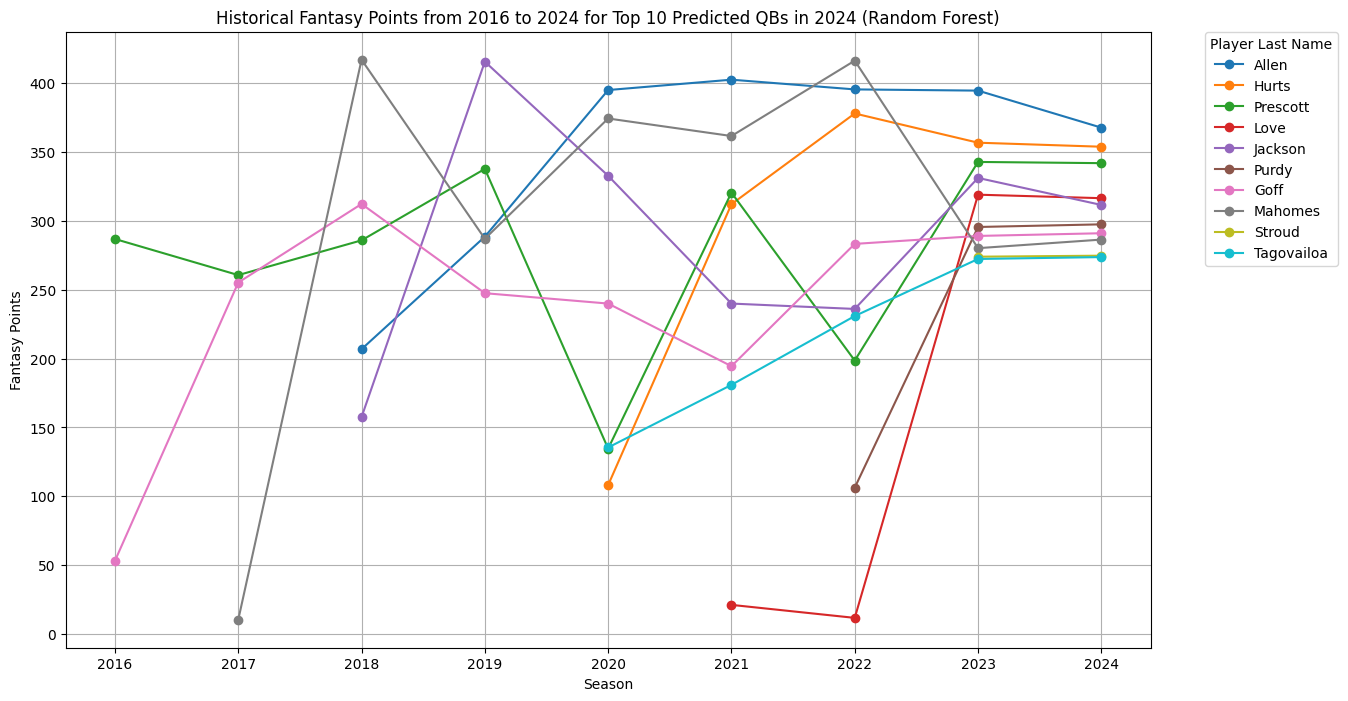

C:\Users\blake\AppData\Local\Temp\ipykernel_23540\561485595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qb['predicted_fantasy_points_2024'] = model_dict_qb[f'qb_{model_name_qb}'].predict(X_qb)


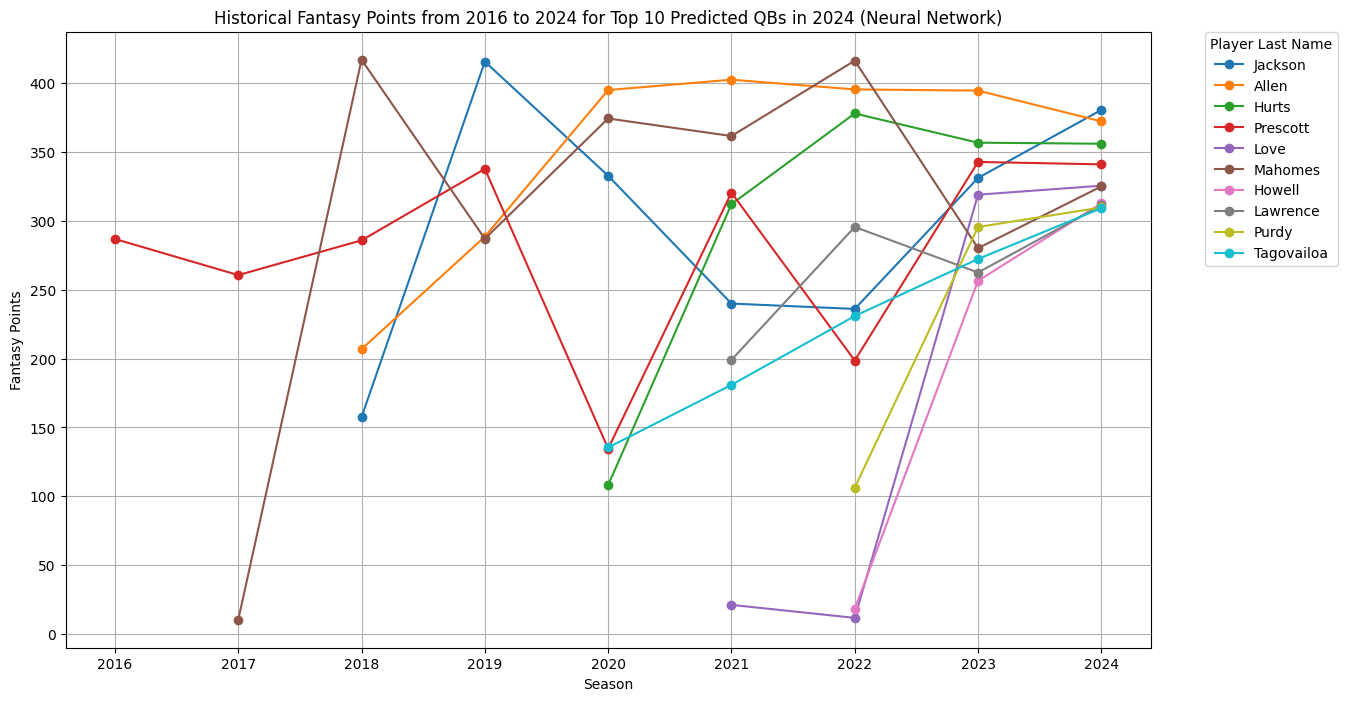

In [12]:
def plot_top_10_qbs(model_dict_qb, model_name_qb, data_qb, qb_features, imputer_qb):
    # Make predictions for 2024
    X_qb = data_qb[qb_features]
    X_qb = pd.DataFrame(imputer_qb.transform(X_qb), columns=X_qb.columns)
    data_qb['predicted_fantasy_points_2024'] = model_dict_qb[f'qb_{model_name_qb}'].predict(X_qb)
    
    # Get top 10 QBs based on their predicted fantasy points for 2024
    top_10_qbs_2024 = data_qb[data_qb['season'] == 2023].sort_values(by='predicted_fantasy_points_2024', ascending=False).head(10)
    top_10_qbs_names = top_10_qbs_2024['name'].tolist()

    # Filter the data
    top_10_historical_qb = NFL_Player_Data[NFL_Player_Data['name'].isin(top_10_qbs_names)]

    # Create a DataFrame for 2024 predictions
    top_10_qbs_2024 = data_qb[data_qb['name'].isin(top_10_qbs_names) & (data_qb['season'] == 2023)][['id', 'name', 'predicted_fantasy_points_2024']].copy()
    top_10_qbs_2024['season'] = 2024
    top_10_qbs_2024.rename(columns={'predicted_fantasy_points_2024': 'fantasy_points'}, inplace=True)

    # Append the 2024 predictions to the historical data
    top_10_historical_with_preds_qb = pd.concat([top_10_historical_qb, top_10_qbs_2024])

    # Plot
    plt.figure(figsize=(14, 8))

    for name in top_10_qbs_names:
        player_data_qb = top_10_historical_with_preds_qb[top_10_historical_with_preds_qb['name'] == name]
        plt.plot(player_data_qb['season'], player_data_qb['fantasy_points'], marker='o', label=name.split()[-1])

    # Labels and title
    plt.xlabel('Season')
    plt.ylabel('Fantasy Points')
    plt.title(f'Historical Fantasy Points from 2016 to 2024 for Top 10 Predicted QBs in 2024 ({model_name_qb})')

    # Legend
    plt.legend(title='Player Last Name', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)

    plt.show()

# Ensure imputer is fit
imputer_qb.fit(data_qb[qb_features])

# Plot all models
plot_top_10_qbs(model_dict_qb, 'Linear Regression', data_qb, qb_features, imputer_qb)
plot_top_10_qbs(model_dict_qb, 'Random Forest', data_qb, qb_features, imputer_qb)
plot_top_10_qbs(model_dict_qb, 'Neural Network', data_qb, qb_features, imputer_qb)


The main issue I have is the projected performance with regression and random forest is way too smoothed of values. The deltas to 2024 don't look believable. I have tried to remove age as it has a p-value higher than .05 but it does not help this. I do not
think these are the right choices for this project despite the excellent R2 score. I will focus on improving my neural network model. 

# Improving Neural Network Model with Hyperarameter Tuning 

In [13]:
# Initialize the model dictionary
model_dict = {}

# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Function to train and evaluate the neural network with hyperparameter tuning
def train_and_evaluate_nn_with_tuning(data, features, target, model_name):
    X = data[features]
    y = data[target]
    
    # Handle missing values using the player's average
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (150, 100), (200, 100)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
    
    # Initialize the neural network model
    nn_model = MLPRegressor(activation='relu', solver='adam', max_iter=2000, random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(nn_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train_scaled, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print(f"Best Model R-squared for {model_name}: {r2:.4f}")
    print("Best parameters found: ", grid_search.best_params_)
    
    # Store the model in the model_dict for further use
    model_dict[model_name] = best_model

    return best_model

# Apply the improved model with hyperparameter tuning to the QB position
nn_improved_qb_tuned = train_and_evaluate_nn_with_tuning(data_qb, qb_features, 'fantasy_points', 'qb_nn_improved_tuned')

# Predict using the retrained model
data_qb['predicted_fantasy_points_2024'] = nn_improved_qb_tuned.predict(scale_features(data_qb[qb_features], data_qb[qb_features])[0])


Best Model R-squared for qb_nn_improved_tuned: 0.9944
Best parameters found:  {'alpha': 0.001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01}


C:\Users\blake\AppData\Local\Temp\ipykernel_23540\4058989918.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qb['predicted_fantasy_points_2024'] = nn_improved_qb_tuned.predict(scale_features(data_qb[qb_features], data_qb[qb_features])[0])


# Final Visual with Updated Model 

C:\Users\blake\AppData\Local\Temp\ipykernel_23540\219049983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qb['predicted_fantasy_points_2024'] = model_dict[model_name].predict(X_qb_scaled)


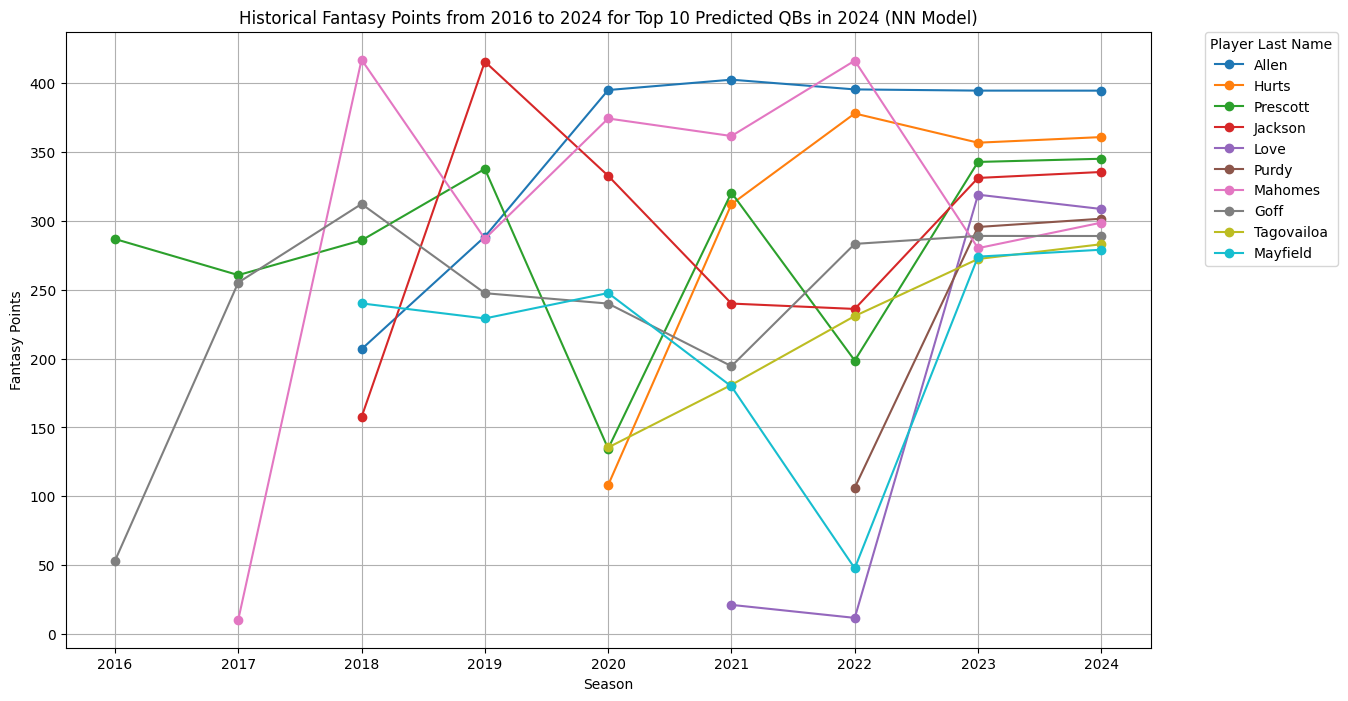

In [14]:
def plot_top_10_qbs_tuned(model_dict, model_name, data_qb, qb_features):
    # Make predictions for 2024 using the tuned model
    X_qb = data_qb[qb_features]
    X_qb_scaled = scale_features(X_qb, X_qb)[0]  # Scale the features using the trained scaler
    data_qb['predicted_fantasy_points_2024'] = model_dict[model_name].predict(X_qb_scaled)
    
    # Filter out players who were not active in 2023 due to retired player issue
    active_qbs_2023 = data_qb[data_qb['season'] == 2023]
    
    # Get top 10 QBs 
    top_10_qbs_2024 = active_qbs_2023.sort_values(by='predicted_fantasy_points_2024', ascending=False).head(10)
    top_10_qbs_names = top_10_qbs_2024['name'].tolist()

    # Filter the data 
    top_10_historical = NFL_Player_Data[NFL_Player_Data['name'].isin(top_10_qbs_names)]

    # Create a DataFrame for 2024 predictions
    top_10_qbs_2024 = data_qb[data_qb['name'].isin(top_10_qbs_names) & (data_qb['season'] == 2023)][['id', 'name', 'predicted_fantasy_points_2024']].copy()
    top_10_qbs_2024['season'] = 2024
    top_10_qbs_2024.rename(columns={'predicted_fantasy_points_2024': 'fantasy_points'}, inplace=True)

    # Append the 2024 predictions to the historical data
    top_10_historical_with_preds = pd.concat([top_10_historical, top_10_qbs_2024])

    # Plot 
    plt.figure(figsize=(14, 8))

    for name in top_10_qbs_names:
        player_data = top_10_historical_with_preds[top_10_historical_with_preds['name'] == name]
        plt.plot(player_data['season'], player_data['fantasy_points'], marker='o', label=name.split()[-1])

    # labels and title
    plt.xlabel('Season')
    plt.ylabel('Fantasy Points')
    plt.title('Historical Fantasy Points from 2016 to 2024 for Top 10 Predicted QBs in 2024 (NN Model)')

    # Legend
    plt.legend(title='Player Last Name', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)

    plt.show()

# Plot 
plot_top_10_qbs_tuned(model_dict, 'qb_nn_improved_tuned', data_qb, qb_features)


# Final Predictions and Export Results 

In [15]:
# Predict 2024 stats for all players in dataset
def train_and_predict_nn_with_tuning(data, features, target, position):
    # Train with updated model, passing the position as the model name
    model_name = f'{position}_nn_improved_tuned'
    model = train_and_evaluate_nn_with_tuning(data, features, target, model_name)
    
    # Predict for 2024
    data[f'predicted_fantasy_points_2024'] = model.predict(scale_features(data[features], data[features])[0])
    
    return data[['name', 'position', f'predicted_fantasy_points_2024']]

# Predictions
predicted_qb = train_and_predict_nn_with_tuning(data_qb, qb_features, 'fantasy_points', 'qb')
predicted_rb = train_and_predict_nn_with_tuning(data_rb, rb_features, 'fantasy_points', 'rb')
predicted_wr = train_and_predict_nn_with_tuning(data_wr, wr_features, 'fantasy_points', 'wr')
predicted_te = train_and_predict_nn_with_tuning(data_te, te_features, 'fantasy_points', 'te')

# Combine into a single DataFrame
predicted_all_positions = pd.concat([predicted_qb, predicted_rb, predicted_wr, predicted_te])

# Sort the combined DataFrame by predicted fantasy points
predicted_all_positions = predicted_all_positions.sort_values(by='predicted_fantasy_points_2024', ascending=False)

# Filter top 20 QBs, 50 WRs, TEs, and RBs for draft day
top_20_qb = predicted_qb.sort_values(by='predicted_fantasy_points_2024', ascending=False).head(20)
top_50_wr = predicted_wr.sort_values(by='predicted_fantasy_points_2024', ascending=False).head(50)
top_50_rb = predicted_rb.sort_values(by='predicted_fantasy_points_2024', ascending=False).head(50)
top_50_te = predicted_te.sort_values(by='predicted_fantasy_points_2024', ascending=False).head(50)

# Combine the top players into a DataFrame for draft day
top_players = pd.concat([top_20_qb, top_50_wr, top_50_rb, top_50_te])

# Export the draft list to an Excel file
top_players.to_excel('top_players_predicted_fantasy_points_2024.xlsx', index=False)
print("Draft list has been saved to 'top_players_predicted_fantasy_points_2024.xlsx'")


Best Model R-squared for qb_nn_improved_tuned: 0.9944
Best parameters found:  {'alpha': 0.001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01}


C:\Users\blake\AppData\Local\Temp\ipykernel_23540\437518169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'predicted_fantasy_points_2024'] = model.predict(scale_features(data[features], data[features])[0])


Best Model R-squared for rb_nn_improved_tuned: 0.9990
Best parameters found:  {'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}


C:\Users\blake\AppData\Local\Temp\ipykernel_23540\437518169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'predicted_fantasy_points_2024'] = model.predict(scale_features(data[features], data[features])[0])


Best Model R-squared for wr_nn_improved_tuned: 0.9984
Best parameters found:  {'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}


C:\Users\blake\AppData\Local\Temp\ipykernel_23540\437518169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'predicted_fantasy_points_2024'] = model.predict(scale_features(data[features], data[features])[0])


Best Model R-squared for te_nn_improved_tuned: 0.9988
Best parameters found:  {'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}


C:\Users\blake\AppData\Local\Temp\ipykernel_23540\437518169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'predicted_fantasy_points_2024'] = model.predict(scale_features(data[features], data[features])[0])


Draft list has been saved to 'top_players_predicted_fantasy_points_2024.xlsx'


# Conclusion 

After plotting the results for the quarterback with the improved neural network model, I still don’t think the predictions are very human or realistic. I think the predictions are overly smooth because there are not enough complex predictors in my model. This was one of the reasons I rejected removing age. I think another approach could have been adding more complex features like weather and strength of schedule. 

The idea that poor weather might reduce passing performance but improve running performance. Similarly, if a team has a weaker bracket they could perform better. But that also opens up new issues on how to determine those things or even find a dataset with that data noted. 
My predictions can be compared to an ESPN analyst here:

https://g.espncdn.com/s/ffldraftkit/24/NFLDK2024_CS_ClayProjections2024.pdf

They use a different scoring format so the fantasy points are different but their top quarterbacks are the same as mine so that is an encouraging result. 
My final output is a cheat sheet to use on draft day. And the key strategy will be to take the players with the highest deltas to their peers. There is no point getting a quarterback as first draft if all the top 10 are within 5 points of each other for an exaggerated example. I will use my predicted players in my neighborhood league this season and see what happens!


# Github Link

https://github.com/blakecdavis10/2024_Fantasy_Football_Prediction.git